<a href="https://colab.research.google.com/github/AnthonySunYi/Verilog_DSL/blob/main/stopwatch_Group_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

The plugin extension is already loaded. To reload it, use:
  %reload_ext plugin


### FPGA Project  
1. Create a new Vivado project for the Basys 3 FPGA board.  
2. Write Verilog code to implement the stopwatch logic.  
3. Map the Verilog design to the Basys 3 board's resources via the basys3 [constraint file](./Demo_Code/basys3_template.xdc) (`.xdc`).   
4. Generate the bitstream file.
5. Program the FPGA board with the bitstream.  
6. Test and debug your stopwatch design on the FPGA board to ensure correct functionality.  
7. Document your design, including the Verilog code, functional diagrams, and challenges faced during implementation.  
8. **Demo Vivado Project**: [T02_Basys3_StopWatch](./Demo_Code/T02_Basys3_StopWatch)


Design and implement a **stopwatch** on the **Basys 3 FPGA** board using Verilog, making use of the **4-digit** **7-segment** display LEDs for time display. The stopwatch should have the following features:  
1. **Reset functionality**: Press a button (e.g., `btnR`) to restart the stopwatch.  
2. **Time Display**: Display the elapsed time in minutes and seconds on the 4-digit 7-segment display.  
3. **Update Frequency**: Update the display at a reasonable frequency (e.g., every 1 second).

# Seven Segment Display for Basys-3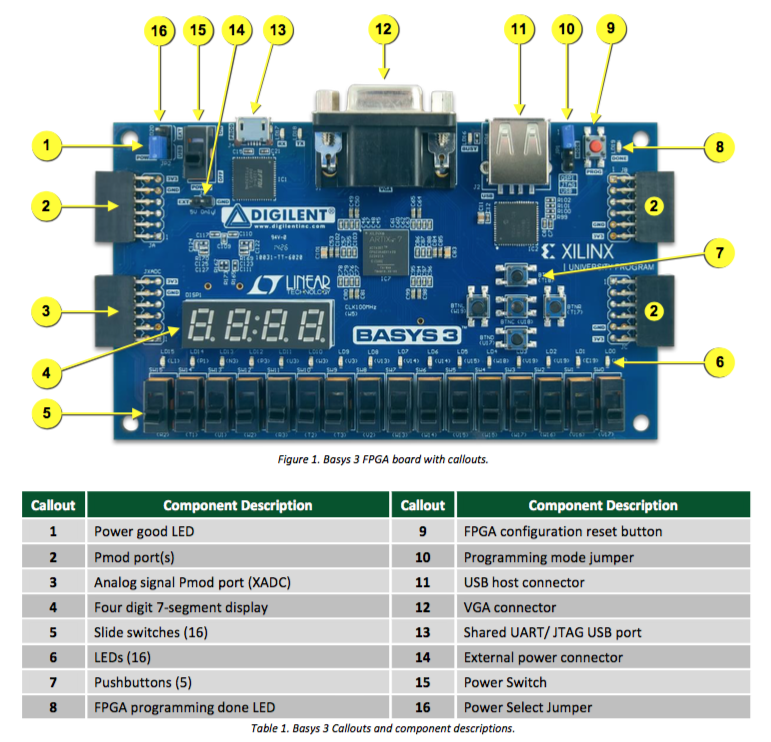

# **Video Demo**
Explantion: In this video we toggle the buttons to showcase the pause and reset functionality
***video***


[link to video demo](https://github.com/LeowYR/DSL_Homework/blob/main/Task02%20Basys%203%20Stopwatch%20Demo.mp4)

# **Logic-gate Code and Testbench**

For the logic gate FPGA, our code and testbench used in the program is shown below.


In [25]:
%%verilog
module stopwatch(
    input clk,        // 100MHz system clock
    input btnR,       // Reset button
    input btnC,       // Start/Stop button
    output reg state,
    output reg [3:0] min_tens,
    output reg [3:0] min_ones,
    output reg [3:0] sec_tens,
    output reg [3:0] sec_ones,
    output reg [3:0] an,    // Anode control for display multiplexing
    output reg [6:0] seg    // 7-segment output
);

    reg [5:0] seconds = 0;  // 0 to 59 seconds
    reg [6:0] minutes = 0;  // 0 to 99 minutes

    // **Start/Stop Mechanism**
    always @(posedge btnC or posedge btnR) begin
        if (btnR)
            state <= 0; // Reset
        else
            state <= ~state; // Toggle state (Start/Stop)
    end

    // **Time Counter**
    always @(posedge clk or posedge btnR) begin
        if (btnR) begin
            seconds <= 0;
            minutes <= 0;
        end
        else if (state) begin  // Increment time if running
            if (seconds == 59) begin
                seconds <= 0;
                if (minutes == 99)
                    minutes <= 0;
                else
                    minutes <= minutes + 1;
            end
            else begin
                seconds <= seconds + 1;
            end
        end
    end

    // **BCD Conversion for Display**
    always @(*) begin
        min_tens = minutes / 10;
        min_ones = minutes % 10;
        sec_tens = seconds / 10;
        sec_ones = seconds % 10;
    end

    // **7-segment Display Multiplexing**
    reg [1:0] mux_count = 0;  // 2-bit counter for multiplexing
    always @(posedge clk) begin
        case (mux_count)
            2'd0: begin seg <= seven_segment(min_tens); an <= 4'b0111; end  // Display min_tens
            2'd1: begin seg <= seven_segment(min_ones); an <= 4'b1011; end  // Display min_ones
            2'd2: begin seg <= seven_segment(sec_tens); an <= 4'b1101; end  // Display sec_tens
            2'd3: begin seg <= seven_segment(sec_ones); an <= 4'b1110; end  // Display sec_ones
        endcase
        mux_count <= mux_count + 1;
    end

    // **7-segment Display Decoder Function**
    function [6:0] seven_segment(input [3:0] digit);
        case (digit)
            4'd0: seven_segment = 7'b1000000;
            4'd1: seven_segment = 7'b1111001;
            4'd2: seven_segment = 7'b0100100;
            4'd3: seven_segment = 7'b0110000;
            4'd4: seven_segment = 7'b0011001;
            4'd5: seven_segment = 7'b0010010;
            4'd6: seven_segment = 7'b0000010;
            4'd7: seven_segment = 7'b1111000;
            4'd8: seven_segment = 7'b0000000;
            4'd9: seven_segment = 7'b0010000;
            default: seven_segment = 7'b1111111;
        endcase
    endfunction

endmodule


//----TESTBENCH----
module stopwatch_tb;
    reg clk;
    reg btnR;
    reg btnC;
    wire state;
    wire [3:0] min_tens;
    wire [3:0] min_ones;
    wire [3:0] sec_tens;
    wire [3:0] sec_ones;
    wire [3:0] an;
    wire [6:0] seg;

    // Instantiate the stopwatch module
    stopwatch uut (
        .clk(clk),
        .btnR(btnR),
        .btnC(btnC),
        .state(state),
        .min_tens(min_tens),
        .min_ones(min_ones),
        .sec_tens(sec_tens),
        .sec_ones(sec_ones),
        .an(an),
        .seg(seg)
    );

    // **Clock Generation**
    always #1 clk = ~clk;  // Toggle clock every 1 time unit

    initial begin
        $dumpfile("stopwatch_tb.vcd");
        $dumpvars(0, stopwatch_tb);
        $dumpon;

        $monitor("Time=%0t clk=%b state=%b btnC=%b btnR=%b sec_ones=%d sec_tens=%d min_ones=%d min_tens=%d an=%b seg=%b",
            $time, clk, state, btnC, btnR, sec_ones, sec_tens, min_ones, min_tens, an, seg);

        // **Initialize Inputs**
        clk = 0;
        btnR = 1;
        btnC = 0;
        #2;  // Hold reset for some time
        btnR = 0;

        // **Start Stopwatch**
        #1 btnC = 1;
        #1 btnC = 0; // Simulating button press

        // **Wait for a few simulated seconds**
        #5;

        // **Pause the Stopwatch**
        #1 btnC = 1;
        #1 btnC = 0;

        // **Observe Display**
        #5;

        // **Resume Stopwatch**
        #1 btnC = 1;
        #1 btnC = 0;

        // **Run for more simulated seconds**
        #5;

        // **Reset the Stopwatch**
        #1 btnR = 1;
        #1 btnR = 0;

        // **End Simulation**
        #40;
        $dumpoff;
        $finish;
    end
endmodule


VCD info: dumpfile stopwatch_tb.vcd opened for output.
Time=0 clk=0 state=0 btnC=0 btnR=1 sec_ones= 0 sec_tens= 0 min_ones= 0 min_tens= 0 an=xxxx seg=xxxxxxx
Time=1 clk=1 state=0 btnC=0 btnR=1 sec_ones= 0 sec_tens= 0 min_ones= 0 min_tens= 0 an=0111 seg=1000000
Time=2 clk=0 state=0 btnC=0 btnR=0 sec_ones= 0 sec_tens= 0 min_ones= 0 min_tens= 0 an=0111 seg=1000000
Time=3 clk=1 state=1 btnC=1 btnR=0 sec_ones= 0 sec_tens= 0 min_ones= 0 min_tens= 0 an=1011 seg=1000000
Time=4 clk=0 state=1 btnC=0 btnR=0 sec_ones= 0 sec_tens= 0 min_ones= 0 min_tens= 0 an=1011 seg=1000000
Time=5 clk=1 state=1 btnC=0 btnR=0 sec_ones= 1 sec_tens= 0 min_ones= 0 min_tens= 0 an=1101 seg=1000000
Time=6 clk=0 state=1 btnC=0 btnR=0 sec_ones= 1 sec_tens= 0 min_ones= 0 min_tens= 0 an=1101 seg=1000000
Time=7 clk=1 state=1 btnC=0 btnR=0 sec_ones= 2 sec_tens= 0 min_ones= 0 min_tens= 0 an=1110 seg=1111001
Time=8 clk=0 state=1 btnC=0 btnR=0 sec_ones= 2 sec_tens= 0 min_ones= 0 min_tens= 0 an=1110 seg=1111001
Time=9 clk=1 state

In [26]:
%%waveform stopwatch_tb.vcd
sign_list = ['stopwatch_tb.clk', 'stopwatch_tb.btnR', 'stopwatch_tb.btnC', 'stopwatch_tb.state', 'stopwatch_tb.min_tens', 'stopwatch_tb.min_ones', 'stopwatch_tb.sec_tens', 'stopwatch_tb.sec_ones', 'stopwatch_tb.uut.seconds', 'stopwatch_tb.uut.minutes', 'stopwatch_tb.an', 'stopwatch_tb.seg']
time_begin = 0
time_end = 1000
base = 'bin'

The code is divided into 3 sections, the clock divider, seven_segment display and debouncer for the buttons.

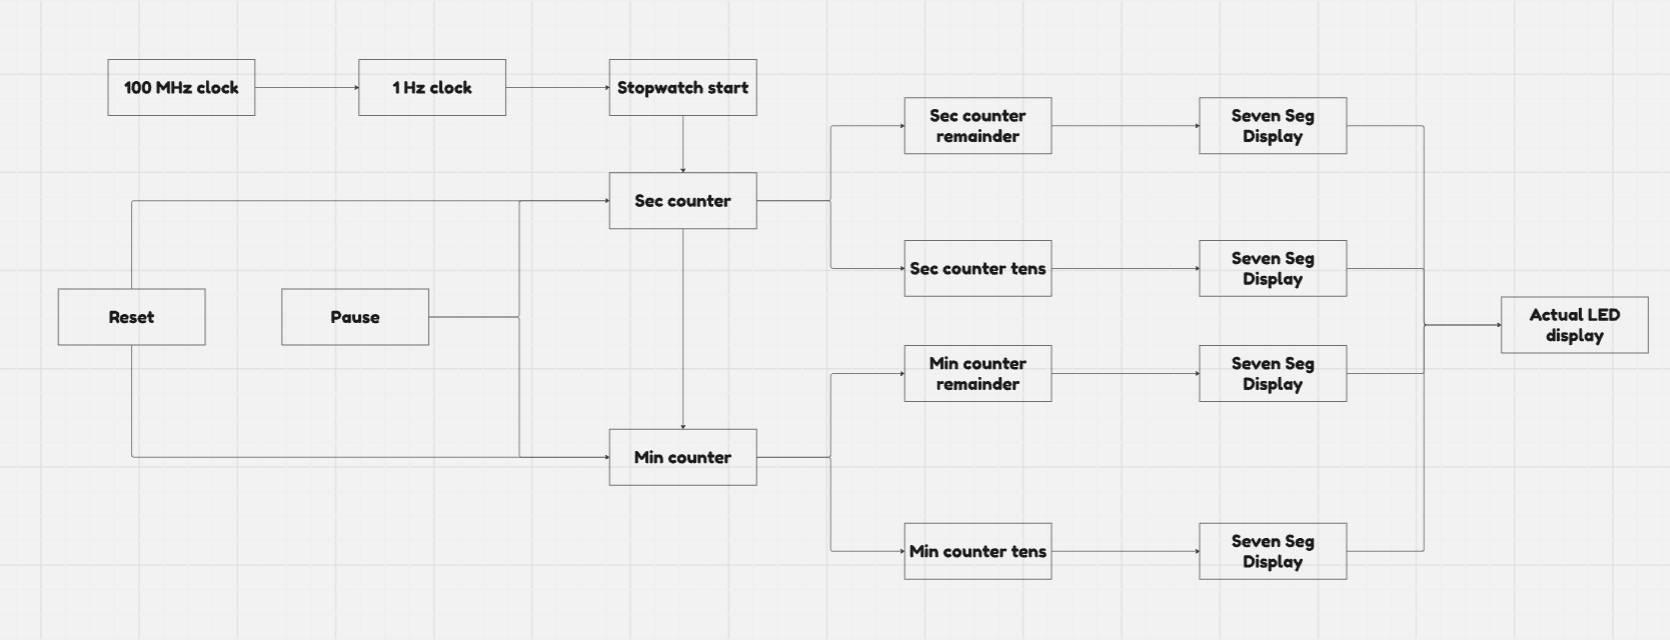

Fig 1 Block diagram for code

Our code can be seen more easily with the block diagram above, I will be tackling the other unseen elements that make the code work below.

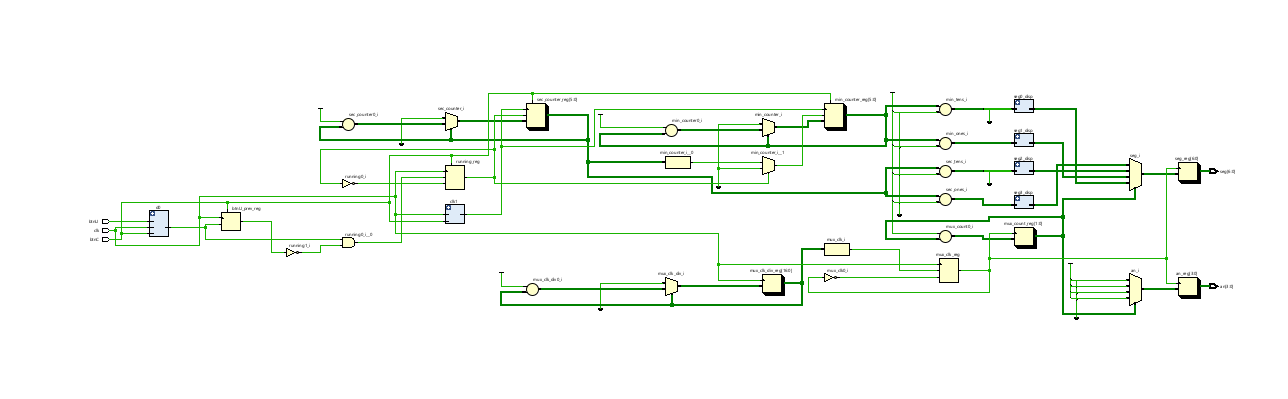

Fig 2 Linter diagram

# Clock Divider

As the Clock of the FPGA is set to 100MHz, we needed to bring the clk down to 1Hz for our stopwatch to work. As such, a clock divider was used where each time the clk was high, the counter would increase by 1 to 100M, where it would output a 1 for the 1Hz_Clk. Thus we were able to use the 100MHz clk as a 1Hz clk.

# Seven_segment display
We included this module as a way for us to split our 4 time data into 1 update at a time, allowing us to send the data required to the specific cell and specific value at a time.

# Debouncer

To enable the buttons to work for the pause and reset, a debouncer would be required to allow the bits to remain as required.

# Constraints

We then inputted this into Vivado, allowing for the Seg, an, as well as BtnC and
BtnU to be unconstrainted as inputs for the FPGA.

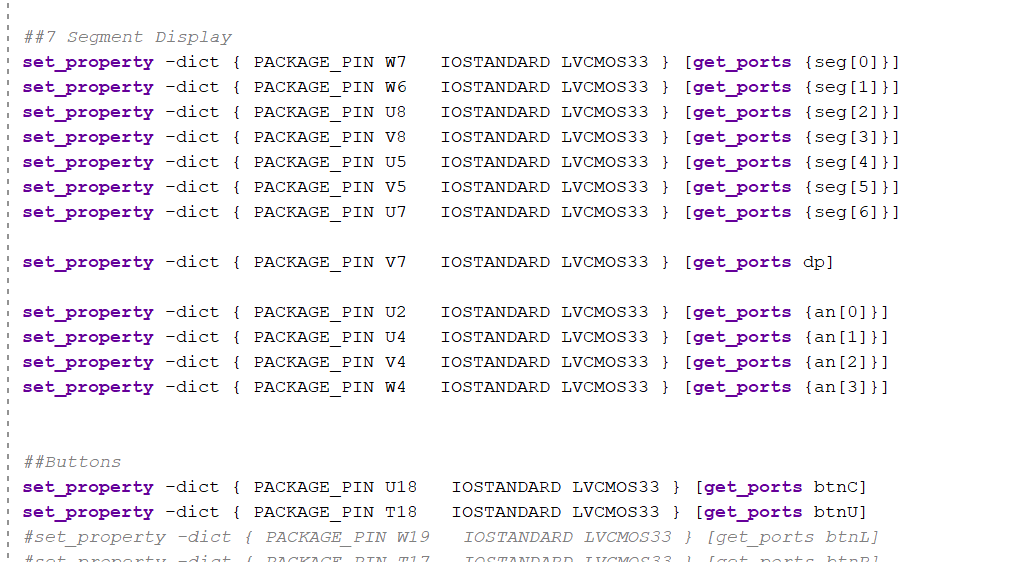


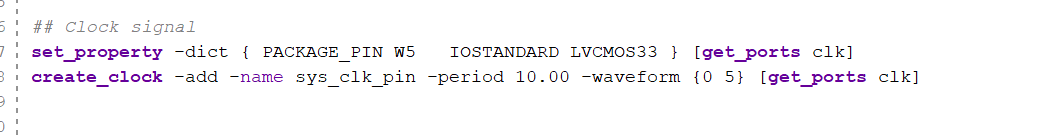
Fig 3 and 4 Constraints file

We then generated a bit-stream and tested the Code in the FPGA as seen in the video above.

# Usage of AI and Design challenges



We primarily used AI to help us with understanding the need of a multiplexor and the implementation of it.

Before using a multiplexor, we came across the problem whereby the output could only represent one digit’s pattern at a time. The other digits would either show the same pattern or be blank, making it impossible to display different values (e.g., "12:34") simultaneously.

In order to display all four digits "simultaneously" on a shared seven-segment display, we need to cycle through them rapidly, activating one digit at a time while sending the appropriate segment pattern (seg[6:0]) for that digit. Each digit is turned on briefly in sequence, and the switching happens very quickly that it appears as if all four digits are lit simultaneously.

The multiplexing clock (mux_clk) is derived by dividing the fast input clock (100 MHz) down to approximately 1 kHz (using mux_clk_div == 17'd99_999). This means each digit is refreshed about 250 times per second (1 kHz / 4 digits = 250 Hz per digit).



> Add blockquote

